DATASET LINK: "https://www.kaggle.com/datasets/pierremegret/dialogue-lines-of-the-simpsons"

In [6]:
import numpy as np
import pandas as pd

In [7]:
import re
from time import time 
from collections import defaultdict
import spacy 

In [8]:
# Setting up the loggings to monitor gensim
import logging 
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [9]:
df= pd.read_csv('simpsons_dataset.csv')

In [10]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [11]:
df.shape

(158314, 2)

Removing Null Values

In [12]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [15]:
df.reset_index(drop=True)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
131848,Miss Hoover,I'm back.
131849,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
131850,Miss Hoover,Psy-cho-so-ma-tic.
131851,Ralph Wiggum,Does that mean you were crazy?


Data Cleaning

In [2]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
nlp= spacy.load('en_core_web_sm', disable=['ner', 'parser'])
# disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    txt= [token.lemma_ for token in doc if not token.is_stop]
    n= len(txt)
    if (n>2):
        return ' '.join(txt)

Word2Vec uses context words to learn the vector representation of a target word, if a sentence is only one or two words long,the benefit for the training is very small.

In [75]:
# Remove non alphabetic chars
def clean_text(row):
    cleaned_row = re.sub("[^A-Za-z']+", ' ', str(row))
    cleaned_row = cleaned_row.lower()
    return cleaned_row

# Apply the cleaning function to each row in the 'spoken_words' column
brief_cleaning = (clean_text(row) for row in df['spoken_words'])

In [19]:
# Speed up using pipelines
t= time()
txt= [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]
print('Time needed to clean up: {} mins'.format(round((time()-t)/60, 2)))


Time needed to clean up: 1.96 mins


In [20]:
df_clean= pd.DataFrame({'clean': txt})
df_clean= df_clean.dropna().drop_duplicates()
df_clean.shape

(85955, 1)

Bigrams

In [21]:
# Gensim Phrases packages automatically detects the common phrases (bigrams) from a list of sentences.
from gensim.models.phrases import Phrases, Phraser

In [22]:
sent= [row.split() for row in df_clean['clean']]

In [23]:
# Phrases takes list of words as input and creates relevant phrases from the list of sentence
phrases= Phrases(sent, min_count=30, progress_per=10000)

INFO - 09:42:05: collecting all words and their counts
INFO - 09:42:05: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 09:42:05: PROGRESS: at sentence #10000, processed 63557 words and 52713 word types
INFO - 09:42:05: PROGRESS: at sentence #20000, processed 130936 words and 99584 word types
INFO - 09:42:05: PROGRESS: at sentence #30000, processed 192961 words and 138126 word types
INFO - 09:42:06: PROGRESS: at sentence #40000, processed 249832 words and 172082 word types
INFO - 09:42:06: PROGRESS: at sentence #50000, processed 311269 words and 207841 word types
INFO - 09:42:06: PROGRESS: at sentence #60000, processed 373578 words and 242828 word types
INFO - 09:42:06: PROGRESS: at sentence #70000, processed 436424 words and 277715 word types
INFO - 09:42:06: PROGRESS: at sentence #80000, processed 497887 words and 310783 word types
INFO - 09:42:06: collected 329494 token types (unigram + bigrams) from a corpus of 537095 words and 85955 sentences
INFO - 09:42:06: m

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task

In [24]:
bigram= Phraser(phrases)

INFO - 09:42:50: exporting phrases from Phrases<329494 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 09:42:51: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<128 phrases, min_count=30, threshold=10.0> from Phrases<329494 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.46s', 'datetime': '2024-06-11T09:42:51.287378', 'gensim': '4.3.2', 'python': '3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


In [25]:
sentences= bigram[sent]

Checking the most frequent words

In [26]:
word_freq= defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i]+= 1
len(word_freq)

29694

In [30]:
sorted(word_freq, key=word_freq.get, reverse=True)[0:20]
# 20 most freq words

['oh',
 'like',
 'know',
 'get',
 'hey',
 'think',
 'come',
 'right',
 'look',
 'want',
 'homer',
 'good',
 'let',
 "'",
 'go',
 'bart',
 'time',
 'go_to',
 'man',
 'uh']

Model Training

In [32]:
from gensim.models import Word2Vec
import multiprocessing

In [34]:
cores= multiprocessing.cpu_count()
cores

16

In [76]:
w2v_model= Word2Vec(min_count=20, window=2, sample=6e-5, alpha=0.03, 
                     min_alpha=0.0007, negative=20, workers=cores-1)

INFO - 10:33:53: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2024-06-11T10:33:53.256068', 'gensim': '4.3.2', 'python': '3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


Buliding Vocabulary

In [38]:
# Vocabulary tree is used for digesting all the words and filtering out the unique words
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)

print()
print('Time taken to build vocab: {} mins'.format(round((time()-t)/60, 2)))

INFO - 09:55:11: collecting all words and their counts
INFO - 09:55:11: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:55:12: PROGRESS: at sentence #10000, processed 61697 words, keeping 9516 word types
INFO - 09:55:12: PROGRESS: at sentence #20000, processed 127312 words, keeping 14382 word types
INFO - 09:55:12: PROGRESS: at sentence #30000, processed 187772 words, keeping 17441 word types
INFO - 09:55:12: PROGRESS: at sentence #40000, processed 243265 words, keeping 20120 word types
INFO - 09:55:12: PROGRESS: at sentence #50000, processed 303120 words, keeping 22550 word types
INFO - 09:55:12: PROGRESS: at sentence #60000, processed 363858 words, keeping 24819 word types
INFO - 09:55:12: PROGRESS: at sentence #70000, processed 425311 words, keeping 26987 word types
INFO - 09:55:12: PROGRESS: at sentence #80000, processed 485433 words, keeping 28822 word types
INFO - 09:55:12: collected 29694 word types from a corpus of 523538 raw words and 85955 sentence


Time taken to build vocab: 0.01 mins


In [40]:
t= time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=50)

print()
print('Time taken to train the model: {} mins'.format(round((time()-t)/60, 2)))

WARNING - 09:56:33: Effective 'alpha' higher than previous training cycles
INFO - 09:56:33: Word2Vec lifecycle event {'msg': 'training model with 15 workers on 3324 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2024-06-11T09:56:33.331278', 'gensim': '4.3.2', 'python': '3.10.4 (tags/v3.10.4:9d38120, Mar 23 2022, 23:13:41) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'train'}
INFO - 09:56:33: EPOCH 0: training on 523538 raw words (199114 effective words) took 0.6s, 318144 effective words/s
INFO - 09:56:34: EPOCH 1: training on 523538 raw words (198952 effective words) took 0.6s, 329871 effective words/s
INFO - 09:56:35: EPOCH 2: training on 523538 raw words (199024 effective words) took 0.6s, 317057 effective words/s
INFO - 09:56:35: EPOCH 3: training on 523538 raw words (199621 effective words) took 0.5s, 388563 effective words/s
INFO - 09:56:36: EPOCH 4: training on 523538 raw words (


Time taken to train the model: 0.51 mins


No model training any further --> init_sims() is called, that makes the model much more memory-efficient

In [41]:
w2v_model.init_sims(replace=True)

C:\Users\klper\AppData\Local\Temp\ipykernel_4312\514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)
WARNING - 09:57:27: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


<div align="center">
  <img src="https://c8.alamy.com/comp/2JK4TGD/homer-simpson-the-simpsons-movie-2007-2JK4TGD.jpg" alt="Simpson" width=200 />
</div>

Model Exploration

In [42]:
# Checking Most Similar words
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.6527020931243896),
 ('want', 0.5358028411865234),
 ('maybe', 0.5338903665542603),
 ('oh', 0.5192403197288513),
 ('right', 0.48853427171707153),
 ('finally', 0.47544968128204346),
 ('dad', 0.46974897384643555),
 ('husband', 0.45921388268470764),
 ('think', 0.4455251097679138),
 ('sorry', 0.4449143409729004)]

In [43]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('welcome', 0.4244907796382904),
 ('sir', 0.41486942768096924),
 ('simpson', 0.41168108582496643),
 ('montgomery_burn', 0.3957066833972931),
 ('year', 0.38972944021224976),
 ('winner', 0.3883499503135681),
 ('local', 0.3825806975364685),
 ('congratulation', 0.3809957802295685),
 ('sector', 0.36563658714294434),
 ('yes', 0.3619401454925537)]

In [44]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.6527020335197449),
 ('want', 0.5280627608299255),
 ('husband', 0.5203080177307129),
 ('oh', 0.47409939765930176),
 ('mom', 0.4461785852909088),
 ('honey', 0.4234790802001953),
 ('way', 0.4223344326019287),
 ('right', 0.41960644721984863),
 ('wife', 0.4072851240634918),
 ('think', 0.3977859914302826)]

Checking Similarity

In [45]:
w2v_model.wv.similarity('maggie', 'baby')

0.45833546

In [50]:
w2v_model.wv.similarity("moe", "tavern")

0.5362973

In [51]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 10:10:28: vectors for words {'kearney'} are not present in the model, ignoring these words


'jimbo'

In [52]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.5840775966644287),
 ('parent', 0.47684958577156067),
 ('mom', 0.4671202003955841)]

T- SNE Visualizations<br>
(It is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space)

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [70]:
def tsneplot(model, word, list_names):
    vector_dim = model.wv[word].shape[0]
    arrays = np.empty((0, vector_dim), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, [model.wv[word]], axis=0)

    # Getting the similiar words and adding to vector
    close_words = model.wv.most_similar(word)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # Adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        if wrd in model.wv:
            wrd_vector = model.wv[wrd]
            word_labels.append(wrd)
            color_list.append('green')
            arrays = np.append(arrays, [wrd_vector], axis=0)
    
    n_components = min(arrays.shape[0], arrays.shape[1], 50)  # 50 or lower PCA Components based on the data
    reduc = PCA(n_components=n_components).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({
        'x': Y[:, 0],
        'y': Y[:, 1],
        'words': word_labels,
        'color': color_list
    })
    
    fig, _ = plt.subplots()
    fig.set_size_inches(7,7)
    
    p1 = sns.regplot(data=df, x="x", y="y",
                     fit_reg=False, marker="o",
                     scatter_kws={'s': 40, 'facecolors': df['color']})
    
    for line in range(df.shape[0]):
        p1.text(df["x"][line], df['y'][line], '  ' + df["words"][line].title(),
                horizontalalignment='left', verticalalignment='bottom', size='medium',
                color=df['color'][line], weight='normal').set_size(15)
    
    plt.xlim(Y[:, 0].min()-20, Y[:, 0].max()+20)
    plt.ylim(Y[:, 1].min()-20, Y[:, 1].max()+20)
            
    plt.title('T-SNE visualization for {}'.format(word.title()))

The query word is represented in **red**, its most similar words in the model in **blue**, and other words from the vocabulary in **green**.

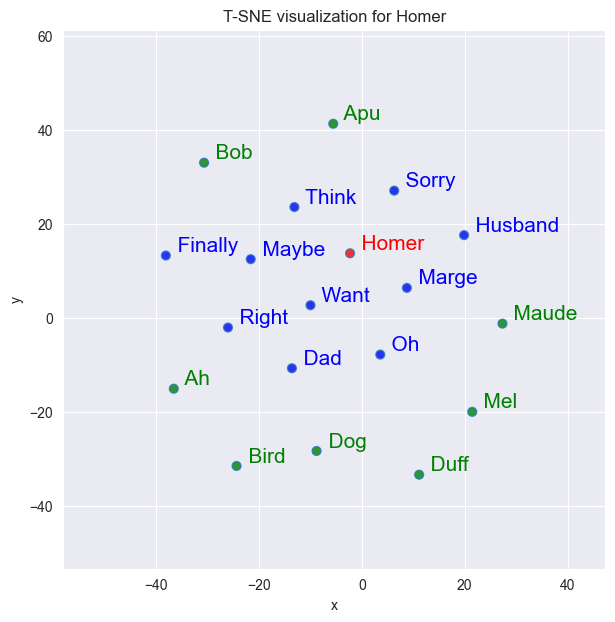

In [72]:
# Comparing Homer with its 10 most similar wordds and some random words
tsneplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

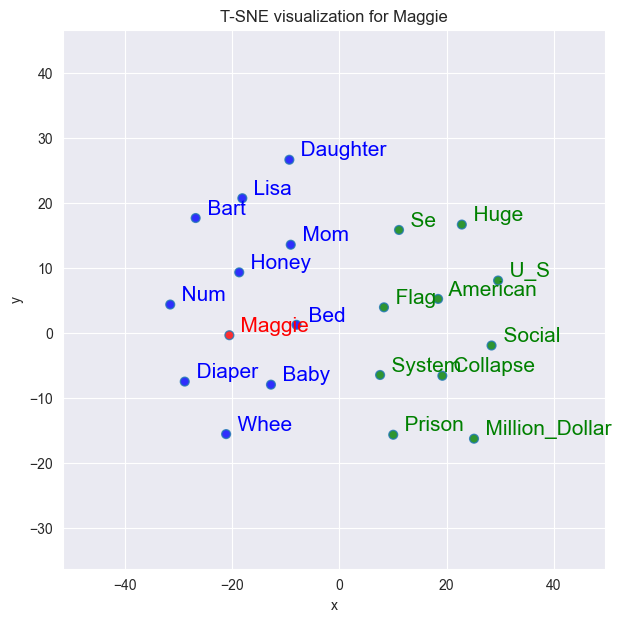

In [74]:
# Most similar vs most dissimilar
tsneplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])